In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))


In [43]:
df = pd.read_csv('complaints3.csv')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2799 entries, 0 to 2798
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       2799 non-null   object
 1   Consumer complaint narrative  2799 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


In [45]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1172
Debt collection                                                                  513
Credit card or prepaid card                                                      326
Mortgage                                                                         279
Checking or savings account                                                      179
Student loan                                                                     130
Vehicle loan or lease                                                             70
Money transfer, virtual currency, or money service                                70
Payday loan, title loan, or personal loan                                         45
Credit reporting                                                                   4
Consumer Loan                                                                      4
Bank account or service                                          

In [46]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [49]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [50]:
print_plot(10)

Original CFPB Complaint # XXXX Against XXXX XXXX XXXX XXXX In XXXX or XXXX we refinanced our XXXX XXXX XXXX XXXX XXXX. The original loan was with XXXX XXXX XXXX XXXX. We refinanced the loan with XXXX XXXX XXXX XXXX ( XXXX ) in XXXX Texas. XXXX called XXXX XXXX XXXX and received a payoff of the loan good till XX/XX/XXXX. XXXX issued a check in the full amount provided by XXXX XXXX XXXX on XX/XX/XXXX. XXXX XXXX XXXX did not submit the check from XXXX until XX/XX/XXXX per XXXX records. XXXX XXXX XXXX began reporting late pays on both my wife 's and my credit reports for the difference between the payoff provided thru XX/XX/XXXX and when they deposited the payoff check on XX/XX/XXXX. These late pays continued through XXXX of XXXX. We only aware of this in accuracy the week of XX/XX/XXXX when working to make a major purchase. XXXX XXXX XXXX XXXX actions are unacceptable based on their internal processing of the check. We should not have been penalized/reported late on our credit reports. Th

In [51]:
print_plot(100)

I have applied a credit card through XXXX XXXX XXXX sometimes in XXXX. 
then I moved to another apartment and missed all the letter they sent me and I never use it even once until now, and then I found out that they reported a late payment of {$140.00} on XX/XX/2019. Then i contacted them to ask what is that fees about and they say it is from me not paying the annual fees so it is became late payment on my credit report and I paid it off so they could correct the report but they did not. so my credit score went down due to their incorrect report.
Product: Credit reporting, credit repair services, or other personal consumer reports


In [52]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [54]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [55]:
print_plot(10)

original cfpb complaint # refinanced original loan refinanced loan teas called received payoff loan good till issued check full amount provided submit check per records began reporting late pays wife credit reports difference payoff provided thru deposited payoff check late pays continued aware accuracy week working make major purchase actions unacceptable based internal processing check penalized reported late credit reports significantly damaged credit rating point unable obtain loan pending purchase attempted resolve matter avail thus far continue receive stall deflect actions point losing option purchase attempting based information provided payoff amount check issued mailed  days prior payoff date provided reported credit reports due inability process payments timely manner issue resolved correct incorrect reporting furnisher year received letter office president outlined steps would take correct wrong reporting attached sent three credit reporting agencies cra equifa correct info

In [56]:
print_plot(100)

applied credit card sometimes moved another apartment missed letter sent never use even found reported late payment   contacted ask fees say paying annual fees became late payment credit report paid could correct report credit score went due incorrect report
Product: Credit reporting, credit repair services, or other personal consumer reports


In [57]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11932 unique tokens.


In [58]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2799, 250)


In [59]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2799, 12)


In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2519, 250) (2519, 12)
(280, 250) (280, 12)


#Model

In [61]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 12)                1212      
                                                                 
Total params: 5,081,612
Trainable params: 5,081,612
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/5
36/36 [==============================] - 31s 783ms/step - loss: 2.0409 - accuracy: 0.3988 - val_loss: 1.6755 - val_accuracy: 0.4524
Epoch 2/5
36/36 [==============================] - 28s 768ms/step - loss: 1.6433 - accuracy: 0.4274 - val_loss: 1.4809 - val_accuracy: 0.4802
Epoch 3/5
36/36 [==============================] - 28s 773ms/step - loss: 1.3482 - accuracy: 0.5329 - val_loss: 1.4235 - val_accuracy: 0.4683
Epoch 4/5
36/36 [==============================] - 28s 779ms/step - loss: 1.1080 - accuracy: 0.6405 - val_loss: 1.2304 - val_accuracy: 0.5952
Epoch 5/5
36/36 [==============================] - 28s 771ms/step - loss: 0.8627 - accuracy: 0.7265 - val_loss: 1.1941 - val_accuracy: 0.6190


In [63]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

9/9 [==============================] - 1s 70ms/step - loss: 1.3324 - accuracy: 0.5393
Test set
  Loss: 1.332
  Accuracy: 0.539


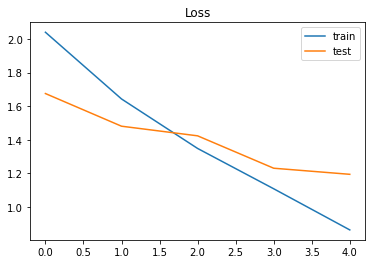

In [64]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

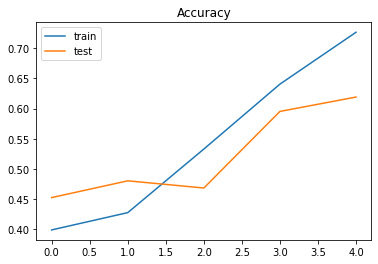

In [65]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [66]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.4262587e-03 9.6389830e-02 6.4392172e-04 7.5022244e-01 1.1397381e-01
  1.5798932e-02 6.7667407e-03 9.5893699e-04 5.0118631e-03 2.8986582e-03
  2.8243964e-03 3.0841921e-03]] Credit card or prepaid card
